In [ ]:
from stumpy.core import (compute_mean_std, sliding_dot_product,
  calculate_distance_profile, apply_exclusion_zone)
import numpy as np
from numba import njit, prange
import numba as nb
from numba.typed import List


class ARIMP():
    """
    Compute the Arbitrary-Range-Indexed Matrix Profile (ARIMP)
    Initializes the Arbitrary Range Index with a window and time series (or two if
    A-B-join). Construction is O(n^2) time-complex and has a worst-case space complexity of
    O(n^2), although for many datasets is nearer to O(nlog(n)). After construction, query
    the Matrix Profile for any exclusive or inclusive, relative or absolute range by
    using 'query' method.
    """
    def __init__(self, T, m, Q=None):

        self.T_A = T
        self.m = m

        if Q:
            self.T_B = Q
            self.M_T, self.Σ_T = compute_mean_std(T, m)
            self.μ_Q, self.σ_Q = compute_mean_std(Q, m)
            self.QT = sliding_dot_product(T[:m], Q)
            self.QT_1st = sliding_dot_product(Q[:m], T)

        else:
            self.T_B = T
            self.M_T, self.Σ_T = compute_mean_std(T, m)
            self.μ_Q, self.σ_Q = self.M_T, self.Σ_T
            self.QT = sliding_dot_product(T[:m], T)
            self.QT_1st = np.copy(self.QT)

        (
          self.SL,
          self.SLI,
          self.SR,
          self.SRI,
          self.RL,
          self.RLI,
          self.LR,
          self.LRI
        ) = _ARIMP(
          self.T_A,
          self.T_B,
          self.m,
          self.QT,
          self.QT_1st,
          self.μ_Q,
          self.σ_Q,
          self.M_T,
          self.Σ_T
        )


    def query(self, start, end, inclusive=True, absolute=True):

        if inclusive:
            self.P, self.I = _query(
              self.m,
              self.T_A.size,
              start,
              end,
              self.SL,
              self.SLI,
              self.SR,
              self.SRI,
              inclusive,
              absolute
            )

        else:
            self.P, self.I = _query(
              self.m,
              self.T_A.size,
              start,
              end,
              self.RL,
              self.RLI,
              self.LR,
              self.LRI,
              inclusive,
              absolute
            )


        return self.P, self.I



@njit(fastmath=True)
def _ARIMP(T_A, T_B, m, QT, QT_1st, μ_Q, σ_Q, M_T, Σ_T, trivial=True):
    """
    Constructs set of data structures (the "Arbitrary Range Index") which contain
    the minimum-so-far distances and indexes that allow arbitrary range queries.

    Parameters
    ----------
    T_A : [float] numpy.ndarray
      Time series to query

    T_B : [float] numpy.ndarray
      Time series to query 'T_A'. If self-join ('trivial=True'),
      T_B is T_A.

    m : int
      Window size

    QT : [float] numpy.ndarray
      Sliding dot product

    QT_1st : [float] numpy.ndarray
      First sliding dot product of T_B[:m] and T_A. If self-join ('trivial=True'),
      QT_1st == QT.

    μ_Q: [float] numpy.ndarray
      Moving average of query.

    σ_Q: [float] numpy.ndarray
      Moving standard deviation of query.

    M_T: [float] numpy.ndarray
      Moving average of time series.

    Σ_T: [float] numpy.ndarray
      Moving standard deviation of time series.

    trivial: bool, default True
      Specify self-join ('trivial=True') or A-B-join ('trivial=False')

    Returns
    -------
    Arbitrary_Range_Index : tuple
      Tuple of numba.typed.Lists in which each contain the minimum-so-far distance or
      index needed for a specific query.
    """

    ex = int(np.ceil(m/4))
    if not trivial:
        ex = 0

    L = T_A.size - m + 1
    L_B = T_B.size - m

    copy = lambda x: List([y.copy() for y in x])
    SL = List([List.empty_list(nb.float64) for _ in range(L)])
    SR, RL, LR =  copy(SL),  copy(SL), copy(SL)

    SLI = List([List.empty_list(nb.int64) for _ in range(L)])
    SRI, RLI, LRI = copy(SLI), copy(SLI), copy(SLI)


    for i in range(L):
    # needs to be converted from row-wise to diagonal-wise computation
        if i == 0:
            D = calculate_distance_profile(m, QT, μ_Q[i], σ_Q[i], M_T, Σ_T)

        else:
            QT[1:] = QT[:L_B] - T_A[i-1] * T_B[:L_B] + T_A[i-1+m] * T_B[-L_B:]
            QT[0] = QT_1st[i]
            D = calculate_distance_profile(m, QT, μ_Q[i], σ_Q[i], M_T, Σ_T)

        if ex != 0: apply_exclusion_zone(D, i, ex)

        _get_SL(D, i, L, SL, SLI) # easily parallelized
        _get_SR(D, i, L, SR, SRI)
        _get_LR(D, i, L, LR, LRI)
        _get_RL(D, i, L, RL, RLI)

    return (SL, SLI, SR, SRI, RL, RLI, LR, LRI)


@njit(fastmath=True)
def _get_SL(D, i, L, SL, SLI):
    """Get left-to-right minimum-so-far for inclusive query"""
    for j in range(i):
        j = i - j
        if D[j] == np.inf:
            continue
        if len(SL[i]) == 0:
            SL[i].append(D[j])
            SLI[i].append(j)
        if D[j] < SL[i][-1]:
            SL[i].append(D[j])
            SLI[i].append(j)

@njit(fastmath=True)
def _get_SR(D, i, L, SR, SRI):
    """Get left-to-right minimum-so-far for inclusive query"""
    for j in range(L - i):
        j = j + i
        if D[j] == np.inf:
            continue
        if len(SR[i]) == 0:
            SR[i].append(D[j])
            SRI[i].append(j)
        if D[j] < SR[i][-1]:
            SR[i].append(D[j])
            SRI[i].append(j)

@njit(fastmath=True)
def _get_LR(D, i, L, LR, LRI):
    """Get left-to-right minimum-so-far for exclusive query"""
    for j in range(L):
        if D[j] == np.inf:
            continue
        if len(LR[i]) == 0:
            LR[i].append(D[j])
            LRI[i].append(j)
        if D[j] < LR[i][-1]:
            LR[i].append(D[j])
            LRI[i].append(j)

@njit(fastmath=True)
def _get_RL(D, i, L, RL, RLI):
    """Get right-to-left minimum-so-far for exclusive query"""
    for j in range(L):
        j = L-1 - j
        if D[j] == np.inf:
            continue
        if len(RL[i]) == 0:
            RL[i].append(D[j])
            RLI[i].append(j)
        if D[j] < RL[i][-1]:
            RL[i].append(D[j])
            RLI[i].append(j)


@njit(fastmath=True)
def _query(m, n, start, end, L, LI, R, RI, inclusive=True, absolute=True):
    """
    Query the Arbitrary Range Index to find the corresponding Matrix Profile

    Parameters
    ----------
    m : int
      Window size

    n : int
      Length of time series

    start : int
      Start index of inclusion/exclusion zone

    end : int
      End index of inclusion/exclusion zone

    L : [float] numba.typed.List
      List of right-to-left minimum-so-far distances

    LI : [int] numba.typed.List
      List of right-to-left minimum-so-far indexes

    R : [float] numba.typed.List
      List of left-to-right minimum-so-far distances

    RI : [int] numba.typed.List
      List of left-to-right minimum-so-far indexes

    inclusive : bool, default True
      Specify an inclusive or exclusive ('inclusive=False') zone

    absolute : bool, default True
      Specify an absolute or relative ('absolute=False') query. If true, 'start' and
      'end' refer to exact indexes of inclusion/exclusion zone. If false, 'start'/'end'
      refer to distance left/right of sliding search query.

    Returns:
    --------
      P : [float] numpy.ndarray
        The matrix profile

      I : [int] numpy.ndarray
        The matrix profile indexes
    """


    s, e = int(np.abs(start)), end

    if absolute:
        incl_range = range(s, e-m+1)
        excl_range = range(s), range(e+1, n-m+1)
    else:
        incl_range = range(n-m+1)
        excl_range = range(n-m+1), range(0)

    if inclusive:
        SL, SLI, SR, SRI = L, LI, R, RI
        P, I = np.zeros(len(incl_range)), np.zeros(len(incl_range))
        j = 0
        for i in incl_range:

            if absolute:
                SL_num = s
                SR_num = e-m+1
            else:
                SL_num = i-s+1
                SR_num = i+e-1

#inclusive-relative queries might benefit from adding self-join
#exclusion zone to start/end distance, not sure what is more
#intuitive/user-friendly;
#as of now unincluded so start/end must be larger than self-join excl_zone

            num = SL_num
            A = SLI[i]
            left = 0
            right = len(A) - 1

            while left <= right:
                mid = (left + right) // 2
                if A[mid] < num:
                    right = mid-1
                else:
                    left = mid+1

            if right >=1:
                iL = right
                vL = SL[i][iL]
            else:
                vL = np.inf


            num = SR_num
            A = SRI[i]
            left = 0
            right = len(A) - 1

            while left <= right:
                mid = (left + right) // 2
                if A[mid] > num:
                    right = mid-1
                else:
                    left = mid+1

            if right >= 1:
                iR = right
                vR = SR[i][iR]
            else:
                vR = np.inf


            if vL < vR:
                P[j] += vL
                I[j] += iL
            elif vR < vL:
                P[j] += vR
                I[j] += iR
            else:
                P[j] += np.inf
                I[j] += -1
            j += 1


    else:
        RL, RLI, LR, LRI = L, LI, R, RI
        P = np.zeros(len(excl_range[0]) + len(excl_range[1]))
        I = np.zeros(len(excl_range[0]) + len(excl_range[1]))
        j = 0
        for r in excl_range:
            for i in r:

                if absolute:
                    RL_num = e
                    LR_num = s
                else:
                    RL_num = i+e
                    LR_num = i-s

#for exclusive-relative queries, it's probably more user-friendly
#to add the initial self-join exclusion zone to start/end distances;
#as of now unincluded so start/end must be larger than self-join excl_zone

                num = RL_num
                A = RLI[i]
                left = 0
                right = len(A) - 1

                while left <= right:
                    mid = (left + right) // 2
                    if A[mid] < num:
                        right = mid-1
                    else:
                        left = mid+1

                if right >=1:
                    iR = right
                    vR = RL[i][iR]
                else:
                    vR = np.inf


                num = LR_num
                A = LRI[i]
                left = 0
                right = len(A) - 1

                while left <= right:
                    mid = (left + right) // 2
                    if A[mid] > num:
                        right = mid-1
                    else:
                        left = mid+1

                if right >= 1:
                    iL = right
                    vL = LR[i][iL]
                else:
                    vL = np.inf


                if vL < vR:
                    P[j] += vL
                    I[j] += iL
                elif vR < vL:
                    P[j] += vR
                    I[j] += iR
                else:
                    P[j] += np.inf
                    I[j] += -1
                j += 1


    return P, I


#for testing purposes:
#absolute-exclusive range test:

# s = stumpy.ARIMP(T, m)
#abs_excl_qry = s.query(start, end, inclusive=False)

#T_excl = np.concatenate([T[:start+m-1], np.atleast_1d(np.nan), T[end+1:] ])

#MP_excl = stumpy.stump(T_excl, m)
#MP_excl = np.concatenate([MP_excl[:start], MP_excl[end+m:] ])

#close = np.isclose(abs_excl_qry[0], MP_excl[:,0].astype(float))
#masked = np.ma.array(abs_excl_qry[0], mask=close)

#masked.count()  consistently outputs from 0 to 5


In [143]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import stumpy

from itertools import chain
itr = chain.from_iterable


plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')

In [ ]:
dfs = []
for year in ["2015", "2016", "2017"]:
    for month in ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]:
        url = f"http://www.pedestrian.melbourne.vic.gov.au/datadownload/{month}_{year}.csv"
        df = pd.read_csv(url)
        dfs.append(df)

df = pd.concat(dfs, ignore_index=True).loc[:, ["Date", "Hour", "Collins Place (North)"]]

ARI_MP = ARIMP(df['Collins Place (North)'].values.astype(float), 120)

stump_MP = stumpy.stump(df['Collins Place (North)'].values.astype(float), 120)

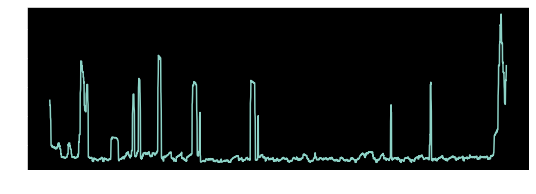

In [311]:
dates = pd.to_datetime(df.Date, dayfirst=True)

# Fig. 7 (Fig. 14 in extended paper)
months = dates[dates.dt.year==2016].groupby(dates.dt.month)
month_dist = [np.zeros(m[1].index[-1]-m[1].index[0]-120+1) for m in months]
month_idx = [x.copy() for x in month_dist]
for i, m in enumerate(months):
    mp = ARI_MP.query(m[1].index[0],m[1].index[-1])
    month_dist[i] += mp[0]
    month_idx[i] += mp[1]

plt.figure(42, (9,3))

plt.plot(list(itr(month_dist)))

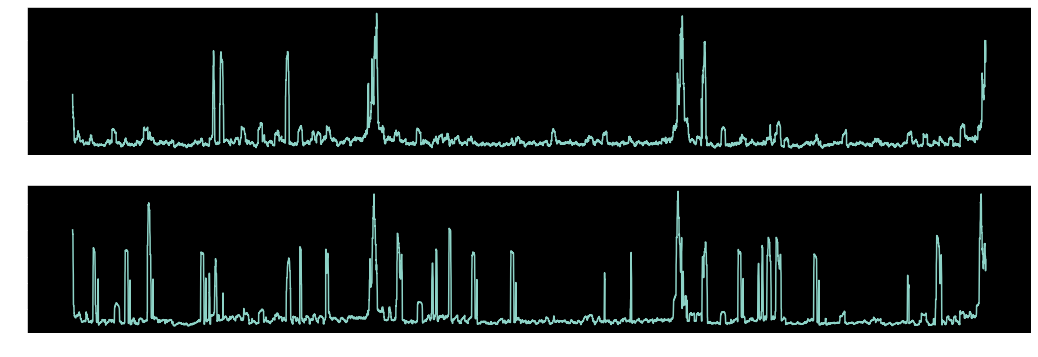

In [312]:
# Fig. 6 (Fig. 13 in ext.)
months = dates.groupby([dates.dt.year,dates.dt.month])
month_dist = [np.zeros(m[1].index[-1]-m[1].index[0]-120+1) for m in months]
month_idx = [x.copy() for x in month_dist]
for i, m in enumerate(months):
    mp = ARI_MP.query(m[1].index[0],m[1].index[-1])
    month_dist[i] += mp[0]
    month_idx[i] += mp[1]

plt.figure(42, (18,6))
plt.subplot(211)
plt.plot(list(itr(month_dist)))
plt.subplot(212)
plt.plot(stump_MP[:,0])

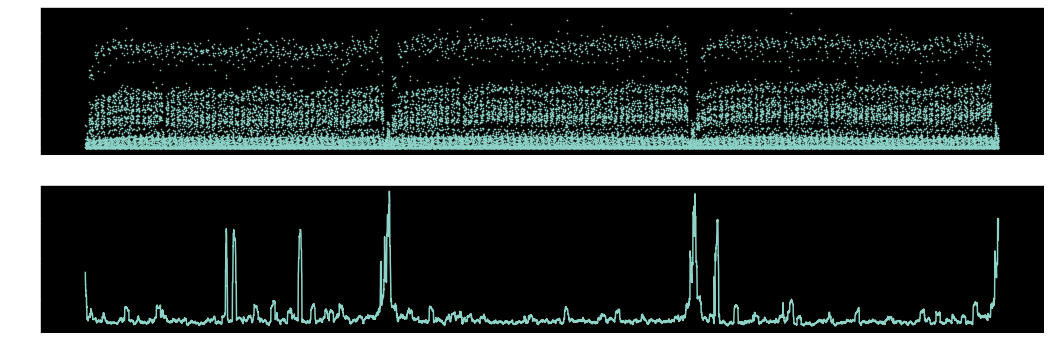

In [313]:
# Fig. 4 (11 in ext.)
# some discrepancy between paper and standard STUMP; there are three peaks in mid 2015 that the paper doesn't show. Nothing in data (holidays etc) to suggest the peaks, and rescraped the dataset with a different method and used different MP algorithms and got same results. Does not affect the ARI queries

plt.figure(42, (18,6))
plt.subplot(211)
plt.scatter(df.index, df['Collins Place (North)'], s=.4)
plt.subplot(212)
plt.plot(stump_MP[:,0])